Load the 2d script

In [73]:
import imp
from astropy.io import fits
import glob, os, sys
twodlvm = imp.load_source('2d_LVM', '2d_projection.py')

Create the spectrograph PSF maps

In [ ]:
twodlvm.get_focus(dir1='libs/',name='focus_lvm_blue1',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)
twodlvm.get_focus(dir1='libs/',name='focus_lvm_red1',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)
twodlvm.get_focus(dir1='libs/',name='focus_lvm_ir1',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)

twodlvm.get_focus(dir1='libs/',name='focus_lvm_blue2',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)
twodlvm.get_focus(dir1='libs/',name='focus_lvm_red2',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)
twodlvm.get_focus(dir1='libs/',name='focus_lvm_ir2',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)

twodlvm.get_focus(dir1='libs/',name='focus_lvm_blue3',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)
twodlvm.get_focus(dir1='libs/',name='focus_lvm_red3',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)
twodlvm.get_focus(dir1='libs/',name='focus_lvm_ir3',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)

Read de output files from the LVM_sim

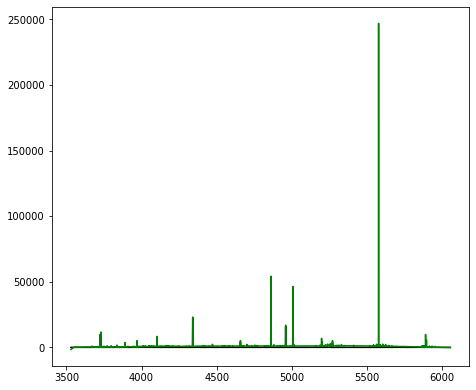

In [87]:
typ='blue'
base_name='reference'
base_name='LVM_customneb2_example'
base_name='LVM_test'
exptime='21600'

cube_file=base_name+'_'+typ+'_full_'+exptime+'_no_noise.fits'
dir_cube='out_lvm_sim/'

hdr0=fits.getheader(dir_cube+cube_file, 0)
Target,hdr1=fits.getdata(dir_cube+cube_file, 1, header=True)
Total,hdr2=fits.getdata(dir_cube+cube_file, 2, header=True)
Err,hdr3=fits.getdata(dir_cube+cube_file, 3, header=True)
SNR,hdr4=fits.getdata(dir_cube+cube_file, 4, header=True)
Sky,hdr5=fits.getdata(dir_cube+cube_file, 5, header=True)
Wave,hdr6=fits.getdata(dir_cube+cube_file, 6, header=True)
hdu_list = fits.open(dir_cube+cube_file)
table_hdu = hdu_list[7]
table_data = table_hdu.data
header = table_hdu.header
fibid=table_data.field('id')
nx,ny=Target.shape

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6.8*1.1,5.5*1.2))
plt.plot(Wave,Target[30,:],'-',color='black')
plt.plot(Wave,Total[30,:],'-',color='green')
#plt.plot(Wave,Err[30,:],'-',color='blue')
#plt.plot(Wave,SNR[30,:],'-',color='gray')
#plt.plot(Wave,Sky[30,:],'-',color='red')
plt.show()

Define the flat exposures

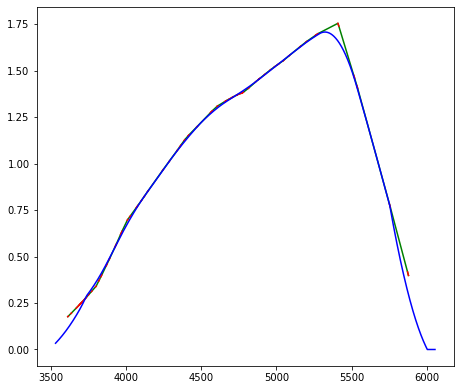

In [88]:
Flat=True
if Flat:
    Target0,hdr1=fits.getdata(dir_cube+cube_file.replace('_no_noise','_input').replace('_21600',''), 1, header=True)

    Rst=Target[30,:]/Target0[30,:]
    Rst=Rst/np.nanmean(Rst)
    nt=np.where(np.isfinite(Rst))
    Wave1=np.copy(Wave)
    Rst1=np.copy(Rst)
    Wave1=Wave1[nt]
    Rst1=Rst1[nt]
    RstN=interp1d(Wave1,Rst1,bounds_error=False,fill_value=0)(Wave) 

    ke=1000
    krn=ke/(Wave[1]-Wave[0])
    from scipy import signal
    ker=signal.gaussian(500, krn )
    ker=ker/np.sum(ker)
    RstM=np.convolve(RstN,ker,mode="same")

    fig, ax = plt.subplots(figsize=(6.8*1.1,5.5*1.2))
    plt.plot(Wave1,Rst1,'-',color='green')
    plt.plot(Wave,Rst,'-',color='red')
    plt.plot(Wave,RstM,'-',color='blue')
    plt.show()

    RstM=RstM*5000


Load the wavelength solution

In [89]:
from scipy.interpolate.interpolate import interp1d
import numpy as np
if typ == 'blue':
    expn='00002998'
    cam='b1'
if typ == 'red':
    expn='00001563'
    cam='r1'
if typ == 'ir':
    expn='00001563'
    cam='z1'
    
cube_file='drp_input/'+typ+'-channel-data/sdR-s-'+cam+'-'+expn+'.disp.fits'
blue_s,hdrB=fits.getdata(cube_file, 0, header=True)
wave_s=np.nanmean(blue_s,axis=0)
nyt=len(wave_s)
pixel=np.arange(0,len(wave_s))

Pix=interp1d(wave_s,pixel,bounds_error=False,fill_value=-10)(Wave)    
    


Run the 2D projection module

In [ ]:
mjd=str(int(hdr0["MJD"]))
expt=hdr0["EXPTIME"]
ra=hdr0["RA"]
dec=hdr0["DEC"]
name=hdr0["TARGET"]
nfib=648
ntt=150
expN=1

spectra=np.zeros([nyt-1000,nfib*3])
indx_t=np.arange(nfib*3,dtype=int)+1
import random
random.shuffle(indx_t)
if Flat:
    nxt=nfib*3
    flb='f'
    n_cr=50
else:
    nxt=nx
    flb='s'
    n_cr=int(150*expt/900.0)
for j in range(800-ntt, nyt-200-ntt):
    for i in range(0, nxt):
        if Flat:
            if i == 0:
                nt=np.where((Pix >= j) & (Pix < j+1))[0]
                val=np.nansum(RstM[nt])
        else:
            nt=np.where((Pix >= j) & (Pix < j+1))[0]
            val=np.nansum(Total[i,nt])
        spectra[j-800+ntt,i]=val

id_t=np.zeros(nfib*3,dtype=int)
id_t[0:nx]=np.copy(fibid)+1
for i in range(nx,nfib*3):
    id_t[i]=i+1
id_t=indx_t
twodlvm.run_2d(spectra,id_t,nfib=nfib,type=typ,cam=1,n_cr=n_cr,expN=expN,expt=expt,ra=ra,dec=dec,mjd=mjd,field_name=name,flb=flb,base_name='sdR')
twodlvm.run_2d(spectra,id_t,nfib=nfib,type=typ,cam=2,n_cr=n_cr,expN=expN,expt=expt,ra=ra,dec=dec,mjd=mjd,field_name=name,flb=flb,base_name='sdR')
twodlvm.run_2d(spectra,id_t,nfib=nfib,type=typ,cam=3,n_cr=n_cr,expN=expN,expt=expt,ra=ra,dec=dec,mjd=mjd,field_name=name,flb=flb,base_name='sdR')

1 b1
1 b2
1 b3
